In [6]:
import sys
sys.path.append('/Users/jpnousu/pyAPES_main')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from pyAPES.utils.iotools import read_forcing
from pyAPES.snow.snow import SnowModel
from pyAPES.snow.srfebal import EnergyBalance
from pyAPES.parameters.mlm_parameters import gpara, cpara, spara, snow # model configuration, canopy parameters, soil parameters
from pyAPES.utils.constants import WATER_DENSITY

In [7]:
soil_dz = 0.05

# Creating EnergyBalance
eb = EnergyBalance(snow)

# Creating SnowModel
snowpack = SnowModel(snow, soil_dz=soil_dz)

In [8]:
fforc = r'/Users/jpnousu/FSM2/met_Sod_1314.txt'
fout = r'/Users/jpnousu/FSM2/Sod_1314_stat.txt'
foutf = r'/Users/jpnousu/FSM2/Sod_1314_flux.txt'
forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))
out = pd.read_csv(fout, header=None, delimiter=r"\s+")
outf = pd.read_csv(foutf, header=None, delimiter=r"\s+")
col_names = ['DIR_SWdown', 'LWdown', 'Snowf', 'Rainf', 'Tair', 'HUMREL', 'Wind', 'PSurf']
forc.columns = col_names

/var/folders/01/f14lxpfj5wl28zjtf5rz8t9c0000gn/T/ipykernel_68006/3595475082.py:4: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  forc = pd.read_csv(fforc, header=None, delimiter=r"\s+", index_col=0, parse_dates={'time': [0,1,2,3]}, date_parser=lambda x: datetime.strptime(x, '%Y %m %d %H'))


In [4]:
# Looping over the forcing file, running forestfloor and soil models for each timestep and saving the results
snow_res = pd.DataFrame()
eb_res = pd.DataFrame()
soil_res = pd.DataFrame()
soil_states = {'temperature': np.array([4, 4])}

for index, row in forcing.iterrows():
    eb_forcing = {
        'cveg': 0.0,
        'Ds1': 5.0,
        'fcans': 0.0,
        'fsnow': snowpack.fsnow,
        'gs1': 0.0,
        'ks1': 0.0,
        'lveg': 0.0,
        'LW': row['LWin'],
        'Ps': row['P'], 
        'RH': 100,
        'SWsrf': row['dirNir'] + row['dirPar'],
        'Sveg': 0.0,
        'SWveg': 0.0,
        'Ta': row['Tair']+KELVIN,
        'tdif': 0.0,
        'Ts1': 0.0,
        'Tveg0': 0.0,
        'Ua': row['U'],
        'VAI': 0.0,
        'vegh': 0.0,
        'zT': 0.0,
        'zU': 0.0,
        'Sice': snowpack.Sice,
    }

    eb_fluxes, eb_states = eb.run(dt=gpara['dt'],
                                  forcing=eb_forcing)

    snow_forcing = {  # Reset the dictionary for each iteration
        'drip': 0, # 
        'Esrf': eb_fluxes['evaporation_surface'], # 
        'Gsrf': eb_fluxes['ground_heat'], # m/s
        'ksoil': soil.heat.thermal_conductivity[0],  #
        'Melt': eb_fluxes['melt'],  #
        'Rf': row['Prec_liquid'],  #
        'Sf': row['Prec_ice'],  #
        'Ta': row['Tair']+KELVIN,  #
        'trans': 0,  #
        'Tsrf': eb_states['surface_temperature'],  # 
        'unload': 0, #
        'Tsoil': soil_states['temperature'][0]+KELVIN, #
    }

    # --- solve snow
    snow_fluxes, snow_states = snowpack.run(
                dt=gpara['dt'],
                forcing=snow_forcing
                )
    
    # Combine results into a single dictionary with all values as floats
    combined_results = {
        'time': index,  # Use the time index from the forcing DataFrame
        **{f'swe_temp': snow_states['snow_water_equivalent']},
        **{f'soil_heat_flux': snow_fluxes['soil_heat_flux']},
        **{f'eb_ground': eb_fluxes['ground_heat']},
        **{f'eb_temp': eb_states['surface_temperature']},
        **{f's_vwc': soil_states['volumetric_water_content'][0]},
    }

    # Append the combined results to the results DataFrame
    snow_res = pd.concat([snow_res, pd.DataFrame([combined_results])], ignore_index=True)

snow_res.set_index('time', inplace=True)

In [13]:
eb_states['surface_temperature']

271.7521367474454

<Axes: >

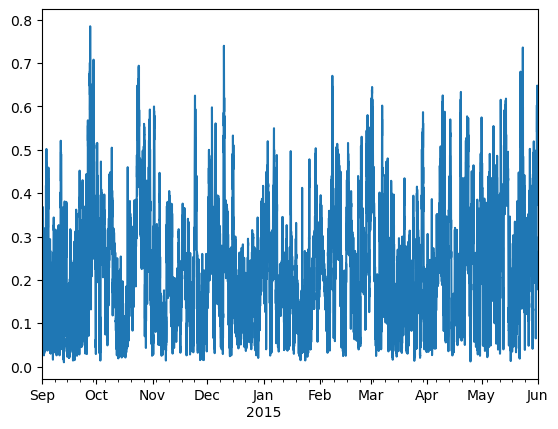

In [29]:
(forcing['Ustar']).plot()

<Axes: >

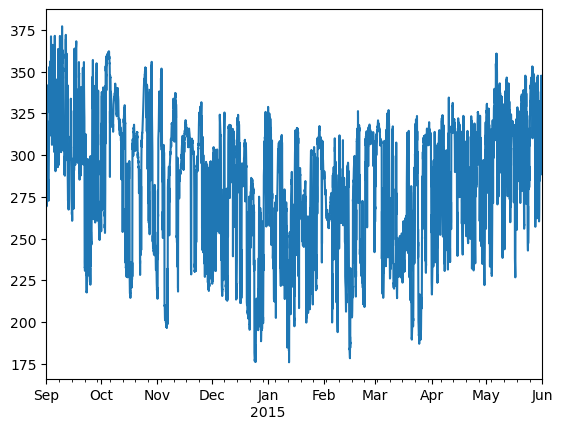

In [21]:
forcing['LWin'].plot()